# Построение моделей машинного обучения для рекомендации тарифа сотовой связи

## 1 Обзор данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None) # позволяет видеть все столбцы

In [2]:
tariffs = pd.read_csv('/datasets/users_behavior.csv')
display('Общие данные по тарифам', tariffs)

'Общие данные по тарифам'

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


<font size="4"><b>Описание данных в таблице:</b></font>

•	сalls — количество звонков,

•	minutes — суммарная длительность звонков в минутах,

•	messages — количество sms-сообщений,

•	mb_used — израсходованный интернет-трафик в Мб,

•	is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

In [3]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


<b>Вывод</b>

Изучив данные можно сказать:

- таблица включает 5 столбцов и 3213 строк (объектов) данных;

- пропусков нет;

- данные приведены к нужным типам;

- таблица будет включать 2 набора данных: признаки - столбцы 'calls', 'minutes', 'messages' и 'mb_used', а также целевой признак столбец 'is_ultra' - пользование тарифом «Ультра» — 1 или «Смарт» — 0;

- перед нами будет стоять задача классификации, целевой признак уже разбит на 2 категории - «Ультра» — 1 и «Смарт» — 0.

## 2 Разбиение данных на выборки

<b>Разобъем таблицу на тренировочную, валидационную и тестовую выборки</b>

In [4]:
# Разобъем таблицу на 2 группы: признаки tariffs_features и целевые признаки tariffs_features
tariffs_features = tariffs.drop(['is_ultra'], axis=1)
tariffs_target = tariffs['is_ultra']

# Разобъем на 2 выборки: обучающую и дополнительную (для валидации и теста)
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    tariffs_features, tariffs_target,
    test_size=0.4, random_state=12345, stratify=tariffs_target)

display(target_train.shape)
display(target_valid_test.shape)

(1928,)

(1286,)

In [5]:
frequency_valid_test = target_valid_test.value_counts(normalize=2/len(target_valid_test))
print(frequency_valid_test)

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64


<b>Относительное соотношение меток 1 и 0 составляет примерно 1/3  единиц и 2/3 - нулей.</b>

In [6]:
# Теперь разобъем и признаки и целевые признаки дополнительной выборки на 2 выборки: валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test,
    test_size=0.5, random_state=12345, stratify=target_valid_test)

display(target_valid.shape)
display(target_test.shape)

(643,)

(643,)

In [7]:
frequency_test = target_test.value_counts(normalize=2/len(target_test))
print(frequency_test)

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64


<b>Относительное соотношение меток 1 и 0 в тестовой выборке составляет примерно 1/3  единиц и 2/3 - нулей.</b>

## 3 Исследуйте модели

### 3.1 Обучим модель Решающее дерево и проверим ее качество

In [10]:
model = DecisionTreeClassifier(random_state=12345) # модель без указания гиперпараметра - глубины
model.fit(features_train, target_train)

# расчёт предсказания модели на обучающей выборке
train_predictions = model.predict(features_train)

# расчёт предсказания модели на валидационной выборке
valid_predictions = model.predict(features_valid)

print("Accuracy:")
# находим accuracy для обучающей выборки по формуле
print("Обучающая выборка:", accuracy_score(target_train, train_predictions))
# находим accuracy для тестовой выборки по формуле
print("Валидационная выборка:", accuracy_score(target_valid, valid_predictions))

Accuracy:
Обучающая выборка: 1.0
Валидационная выборка: 0.7013996889580093


Проверим качество Решающего дерева при изменении гиперпараметра - максимальной глубины

In [11]:
# Проверим какая глубина наиболее оптимальна для максимального Accuracy (max_depth от 1 до 10 )
accuracy_list = [] # список для построения графика
depth_list = [] # список для построения графика

best_model_tree = None
best_accuracy_tree = 0
print("Accuracy:")
for depth in range(1, 11):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    valid_predictions = model_tree.predict(features_valid) # предсказание модели на валидационной выборке
    train_predictions = model_tree.predict(features_train) # предсказание модели на обучающей выборке
    accuracy = accuracy_score(target_valid, valid_predictions) # accuracy для валидационной выборки по формуле
    accuracy_tr = accuracy_score(target_train, train_predictions) # accuracy для обучающей выборки по формуле
    accuracy_list.append(accuracy)
    depth_list.append(depth)
    print('Максимальная глубина дерева =', depth, ' Обучающая выборка:', accuracy_tr, ' Валидационная выборка:', accuracy)
    if accuracy > best_accuracy_tree:
        best_model_tree = model_tree # наилучшая модель
        best_accuracy_tree = accuracy # наилучшее значение accuracy на валидационных данных
    
    # из списков получаем таблицу для построения графика
    list_tuples = list(zip(depth_list, accuracy_list))
    tree_accuracy_depth = pd.DataFrame(list_tuples, columns=['max_depth', 'accuracy'])
print('\n')
print("Accuracy наилучшей модели Решающее дерево на валидационной выборке:", best_accuracy_tree)
display(tree_accuracy_depth)

Accuracy:
Максимальная глубина дерева = 1  Обучающая выборка: 0.7546680497925311  Валидационная выборка: 0.7402799377916018
Максимальная глубина дерева = 2  Обучающая выборка: 0.7759336099585062  Валидационная выборка: 0.7729393468118196
Максимальная глубина дерева = 3  Обучающая выборка: 0.7909751037344398  Валидационная выборка: 0.7776049766718507
Максимальная глубина дерева = 4  Обучающая выборка: 0.7971991701244814  Валидационная выборка: 0.7542768273716952
Максимальная глубина дерева = 5  Обучающая выборка: 0.8137966804979253  Валидационная выборка: 0.7853810264385692
Максимальная глубина дерева = 6  Обучающая выборка: 0.8283195020746889  Валидационная выборка: 0.7744945567651633
Максимальная глубина дерева = 7  Обучающая выборка: 0.8412863070539419  Валидационная выборка: 0.7869362363919129
Максимальная глубина дерева = 8  Обучающая выборка: 0.8558091286307054  Валидационная выборка: 0.80248833592535
Максимальная глубина дерева = 9  Обучающая выборка: 0.8718879668049793  Валидаци

,max_depth,accuracy
0,1,0.740280
1,2,0.772939
2,3,0.777605
3,4,0.754277
4,5,0.785381
5,6,0.774495
6,7,0.786936
7,8,0.802488
8,9,0.782271
9,10,0.772939


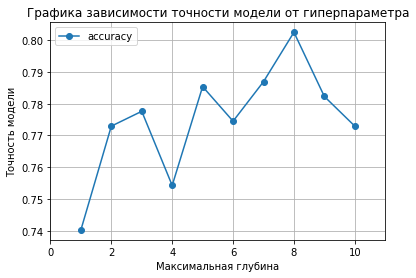

In [12]:
# График зависимости точности модели (accuracy) от гиперпараметра (max_depth)
tree_accuracy_depth.plot(x='max_depth', y='accuracy', style='o-', xlim=(0, 11), grid=True)
plt.title('Графика зависимости точности модели от гиперпараметра')
plt.xlabel('Максимальная глубина')
plt.ylabel('Точность модели')
plt.show()

<b>Вывод</b>

В результате проверки модели Решающее дерево - наилучшее качество для данной модели достигается при гиперпараметре - максимальной глубине равной '8'. Accuracy в данном случае будет равно '0.8024'.

### 3.2 Обучим модель Случайный лес и проверим ее качество

Для модели Случайный лес проверим гиперпараметры - 'n_estimators' - количество деревьев и максимальную глубину - 'max_depth'.

In [13]:
# Проверим модель случайный лес с двумя гиперпараметрами
accuracy_forest_list = [] # список для построения графика
estimators_forest_list = [] # список для построения графика
depth_forest_list = [] # список для построения графика

best_model = None
best_accuracy = 0
for est in range(1, 11):
    for depth in range(1, 11):
        model_randomforest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_randomforest.fit(features_train, target_train)
        accuracy_train = model_randomforest.score(features_train, target_train) # качество модели на тренировочной выборке
        accuracy_valid = model_randomforest.score(features_valid, target_valid) # качество модели на валидационной выборке
        accuracy_forest_list.append(accuracy_valid)
        estimators_forest_list.append(est)
        depth_forest_list.append(depth)
        print('Количество деревьев =', est, ' Тренировочная выборка:', accuracy_train, ' Валидационная выборка:', accuracy_valid)
        if accuracy_valid > best_accuracy:
            best_model = model_randomforest # наилучшая модель
            best_accuracy = accuracy_valid # наилучшее значение accuracy на валидационных данных

        # из списков получаем таблицу для построения графика
        list_tuples = list(zip(estimators_forest_list, depth_forest_list, accuracy_forest_list))
        forest_accuracy_est_depth = pd.DataFrame(list_tuples, columns=['estimators', 'max_depth', 'accuracy'])
        
print('\n')
print("Accuracy наилучшей модели Случайный лес на валидационной выборке:", best_accuracy)
display(forest_accuracy_est_depth)
display(forest_accuracy_est_depth.query('accuracy == 0.807153965785381'))

Количество деревьев = 1  Тренировочная выборка: 0.7359958506224067  Валидационная выборка: 0.7480559875583204
Количество деревьев = 1  Тренировочная выборка: 0.7733402489626556  Валидационная выборка: 0.776049766718507
Количество деревьев = 1  Тренировочная выборка: 0.7733402489626556  Валидационная выборка: 0.776049766718507
Количество деревьев = 1  Тренировочная выборка: 0.7780082987551867  Валидационная выборка: 0.7480559875583204
Количество деревьев = 1  Тренировочная выборка: 0.7966804979253111  Валидационная выборка: 0.7713841368584758
Количество деревьев = 1  Тренировочная выборка: 0.8143153526970954  Валидационная выборка: 0.7791601866251944
Количество деревьев = 1  Тренировочная выборка: 0.8158713692946058  Валидационная выборка: 0.7433903576982893
Количество деревьев = 1  Тренировочная выборка: 0.8293568464730291  Валидационная выборка: 0.776049766718507
Количество деревьев = 1  Тренировочная выборка: 0.8485477178423236  Валидационная выборка: 0.7573872472783826
Количество де

,estimators,max_depth,accuracy
0,1,1,0.748056
1,1,2,0.776050
2,1,3,0.776050
3,1,4,0.748056
4,1,5,0.771384
...,...,...,...
95,10,6,0.804044
96,10,7,0.793157
97,10,8,0.797823
98,10,9,0.804044


,estimators,max_depth,accuracy
55,6,6,0.807154


<b>Проверка модели с одним гиперпараметром для сравнения.</b>

In [15]:
best_model = None
best_accuracy = 0
for est in range(1, 11):
    model_randomforest = RandomForestClassifier(random_state=12345, n_estimators=est)
    model_randomforest.fit(features_train, target_train)
    valid_predictions = model_randomforest.predict(features_valid) # предсказание модели на валидационной выборке
    accuracy = accuracy_score(target_valid, valid_predictions) # accuracy для обучающей выборки по формуле
    print('Количество деревьев =', est, ':', accuracy)
    if accuracy > best_accuracy:
        best_model = model_randomforest # наилучшая модель
        best_accuracy = accuracy # наилучшее значение accuracy на валидационных данных

print('\n')
print("Accuracy наилучшей модели на валидационной выборке:", best_accuracy)

Количество деревьев = 1 : 0.6998444790046656
Количество деревьев = 2 : 0.7433903576982893
Количество деревьев = 3 : 0.7418351477449455
Количество деревьев = 4 : 0.7558320373250389
Количество деревьев = 5 : 0.7527216174183515
Количество деревьев = 6 : 0.7729393468118196
Количество деревьев = 7 : 0.7698289269051322
Количество деревьев = 8 : 0.776049766718507
Количество деревьев = 9 : 0.7698289269051322
Количество деревьев = 10 : 0.7869362363919129


Accuracy наилучшей модели на валидационной выборке: 0.7869362363919129


<b>Вывод</b>

В результате проверки модели Случайный лес - наилучшее качество для данной модели достигается при гиперпараметрах - количество деревьев равном - '6' и максимальная глубина - '6'. Accuracy в данном случае будет равно '0.8071'.

### 3.3 Обучим модель Логистическая регрессия и проверим ее качество

Для модели Логическая регрессия используем гиперпараметры: solver='lbfgs' - алгоритм построения модели и max_iter - максимальное количество итераций обучения.

In [16]:
best_model_lregression = None
best_accuracy_lregression = 0
for iter in range(100, 1100, 100):
    model_lregression = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iter)
    model_lregression.fit(features_train, target_train)
    valid_predictions_lregression = model_lregression.predict(features_valid) # предсказание модели на валидационной выборке
    accuracy_lregression = accuracy_score(target_valid, valid_predictions_lregression) # accuracy для валидационной выборки по формуле
    print('Количество итераций =', iter, 'Валидационная выборка:', accuracy_lregression)
    if accuracy_lregression > best_accuracy_lregression:
        best_model_lregression = model_lregression # наилучшая модель
        best_accuracy_lregression = accuracy_lregression # наилучшее значение accuracy на валидационных данных

print('\n')
print("Accuracy наилучшей модели Логистической регрессии на валидационной выборке:", best_accuracy_lregression)

Количество итераций = 100 Валидационная выборка: 0.7387247278382582
Количество итераций = 200 Валидационная выборка: 0.7387247278382582
Количество итераций = 300 Валидационная выборка: 0.7387247278382582
Количество итераций = 400 Валидационная выборка: 0.7387247278382582
Количество итераций = 500 Валидационная выборка: 0.7387247278382582
Количество итераций = 600 Валидационная выборка: 0.7387247278382582
Количество итераций = 700 Валидационная выборка: 0.7387247278382582
Количество итераций = 800 Валидационная выборка: 0.7387247278382582
Количество итераций = 900 Валидационная выборка: 0.7387247278382582
Количество итераций = 1000 Валидационная выборка: 0.7387247278382582


Accuracy наилучшей модели Логистической регрессии на валидационной выборке: 0.7387247278382582


<b>Вывод</b>

В результате проверки модели Логистическая регрессия - качество данной модели равно '0.7387'.

Количество итераций судя по результатам не оказало воздействия на качество модели.

<b>Вывод по пункту 3</b>

<b>В результате проверки качества моделей Решающее дерево, Случайный лес и Логистическая регрессия наибольшее значение качества (Accuracy) показала модель Решающее дерево с максимальной глубиной равной '8' и значением accuracy равным '0.8024'.</b>

## 4 Проверка модель на тестовой выборке

### Проверим модель Случайный лес на тестовой выборке 

In [17]:
# Для проверки используем модель Случайный лес с максимальной глубиной - '6' и количеством деревьев - '6'
model_randomforest_t = RandomForestClassifier(random_state=12345, n_estimators=6, max_depth=6)
model_randomforest_t.fit(features_train, target_train)
accuracy_train = model_randomforest_t.score(features_train, target_train) # качество модели на обучающей выборке
accuracy_test = model_randomforest_t.score(features_test, target_test) # качество модели на тестовой выборке
print('Тренировочная выборка:', accuracy_train, '| Тестовая выборка:', accuracy_test)

Тренировочная выборка: 0.8319502074688797 | Тестовая выборка: 0.8102643856920684


<b>Общий вывод</b>

В ходе проведенной работы проведены:

- обзор и подготовка данных для обучения моделей;

- обучение трех моделей для задачи классификации: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression и анализ качества данных моделей в зависимости от гиперпараметров;

- проверка наилучшей модели на тестовой выборке.

В целях проверки модели на тестовой выборке выбрана модель Случайный лес с наилучшими гиперпараметрами: максимальной глубиной равной '6' и количеством деревьев - '6'. В результате проверки модели RandomForestClassifier на тестовой выборке качество модели составило '0.8102', что превысило значение '0.75', заданное по условию. Цель достигнута.